In [ ]:
from datasets import load_dataset

In [ ]:
ds = load_dataset("trl-lib/tldr")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/110M [00:00<?, ?B/s]

data/validation-00000-of-00001.parquet:   0%|          | 0.00/6.11M [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/6.21M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/116722 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/6447 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/6553 [00:00<?, ? examples/s]

In [ ]:
import pandas as pd

train_set = pd.DataFrame(ds["train"])
print(ds.keys())

dict_keys(['train', 'validation', 'test'])


In [ ]:
train_set.shape

(116722, 2)

In [ ]:
print(train_set.sample(random_state=56).prompt.values[0])

SUBREDDIT: r/AskReddit

TITLE: Is my school extorting me?

POST: I received a parking ticket last Monday from my school.  I had bought a parking pass for the year for school, and due to circumstances beyond my control, the pass found itself locked in my dads truck 20 minutes from home in the opposite direction of school.  

I took my parents car to school (both vehicles are registered with the school on the parking pass) and received a parking ticket for "failing to show a valid permit.".  I appealed the ticket online through the school's website on Tuesday, and I received back a PDF file on Wednesday morning informing me that my appeal was denied (no explanation).  I then emailed the manager Thursday afternoon explaining the situation and asking for an explanation.  

Fast forward to today (Monday).  I still haven't heard back from the manager and if I don't pay the ticket by tonight, the fee will go from $30 to $45.  I'm strapped for cash, but have no choice but to pay it, because I 

In [ ]:
print(train_set.sample(random_state=56).completion.values[0])

 Parking pass registered for 2 vehicles was left at home.  Appeal was denied, nobody has responded. Fee increases tomorrow.


In [ ]:
print(train_set.prompt.head(1).values[0])

SUBREDDIT: r/relationships

TITLE: I (f/22) have to figure out if I want to still know these girls or not and would hate to sound insulting

POST: Not sure if this belongs here but it's worth a try. 

Backstory:
When I (f/22) went through my first real breakup 2 years ago because he needed space after a year of dating roand  it effected me more than I thought. It was a horrible time in my life due to living with my mother and finally having the chance to cut her out of my life. I can admit because of it was an emotional wreck and this guy was stable and didn't know how to deal with me. We ended by him avoiding for a month or so after going to a festival with my friends. When I think back I wish he just ended. So after he ended it added my depression I suffered but my friends helped me through it and I got rid of everything from him along with cutting contact. 

Now: Its been almost 3 years now and I've gotten better after counselling and mild anti depressants. My mother has been out of

In [ ]:
print(train_set.prompt.head(1).str.extract(r'TITLE: ((.|\n)*)\n\nPOST:').values[0][0])

I (f/22) have to figure out if I want to still know these girls or not and would hate to sound insulting


In [ ]:
print(train_set.prompt.head(1).values)

["SUBREDDIT: r/relationships\n\nTITLE: I (f/22) have to figure out if I want to still know these girls or not and would hate to sound insulting\n\nPOST: Not sure if this belongs here but it's worth a try. \n\nBackstory:\nWhen I (f/22) went through my first real breakup 2 years ago because he needed space after a year of dating roand  it effected me more than I thought. It was a horrible time in my life due to living with my mother and finally having the chance to cut her out of my life. I can admit because of it was an emotional wreck and this guy was stable and didn't know how to deal with me. We ended by him avoiding for a month or so after going to a festival with my friends. When I think back I wish he just ended. So after he ended it added my depression I suffered but my friends helped me through it and I got rid of everything from him along with cutting contact. \n\nNow: Its been almost 3 years now and I've gotten better after counselling and mild anti depressants. My mother has 

In [ ]:
print(train_set.prompt.head(1).str.extract(r'POST: ((.|\n)*)\nTL;DR:', expand=False).values[0][0])

Not sure if this belongs here but it's worth a try. 

Backstory:
When I (f/22) went through my first real breakup 2 years ago because he needed space after a year of dating roand  it effected me more than I thought. It was a horrible time in my life due to living with my mother and finally having the chance to cut her out of my life. I can admit because of it was an emotional wreck and this guy was stable and didn't know how to deal with me. We ended by him avoiding for a month or so after going to a festival with my friends. When I think back I wish he just ended. So after he ended it added my depression I suffered but my friends helped me through it and I got rid of everything from him along with cutting contact. 

Now: Its been almost 3 years now and I've gotten better after counselling and mild anti depressants. My mother has been out of my life since then so there's been alot of progress. Being stronger after learning some lessons there been more insight about that time of my life

In [ ]:
record = train_set.sample(random_state=34)

In [ ]:
print(record.prompt.values[0])

SUBREDDIT: r/AskReddit

TITLE: Am I a pussy for not not fighting a thug on the subway?

POST: I'm on the subway in LA going to downtown to barhop with my girlfriend and some friends. I'm talking to my friends and a black guy eavesdropping thinks I said something racist towards Hispanics. Said black guy, who obviously has been in the system, asks me if he thinks he could kick my ass. I say"It doesn't matter I don't want to fight." He says "I'll fuck you up, bitch". I then take a verbal assault in front of my gf and friends because regardless of if I think I could take him I still don't want to fight. I have a college education and am studying to be a CPA. I have something to lose, he is picking fights with strangers so I'm sure he is abiding by jail/prison rules and starting shit with everyone to prove his dominance.

Am I a pussy because I didn't fight him? I think if I would have fought him and lost my gf would respect me more but it would affect me more in the long run at work and in

In [ ]:
print(record.prompt_title.values[0])

Am I a pussy for not not fighting a thug on the subway?


In [ ]:
print(record.prompt_post.values[0])

I'm on the subway in LA going to downtown to barhop with my girlfriend and some friends. I'm talking to my friends and a black guy eavesdropping thinks I said something racist towards Hispanics. Said black guy, who obviously has been in the system, asks me if he thinks he could kick my ass. I say"It doesn't matter I don't want to fight." He says "I'll fuck you up, bitch". I then take a verbal assault in front of my gf and friends because regardless of if I think I could take him I still don't want to fight. I have a college education and am studying to be a CPA. I have something to lose, he is picking fights with strangers so I'm sure he is abiding by jail/prison rules and starting shit with everyone to prove his dominance.

Am I a pussy because I didn't fight him? I think if I would have fought him and lost my gf would respect me more but it would affect me more in the long run at work and in my future career.



### Extracting the Title and the Post from the dataset into seperate columns.

In [ ]:

for set_type in ds.keys():
  ds[set_type] = pd.DataFrame(ds[set_type])
  ds[set_type]["prompt_post"] = ds[set_type].prompt.str.extract(
      r'POST: ((.|\n)*)\nTL;DR:', expand=False
  ).iloc[:, 0]
  ds[set_type]["prompt_title"] = ds[set_type].prompt.str.extract(
    r'TITLE: ((.|\n)*)\n\nPOST:', expand=False
  ).iloc[:, 0]


In [ ]:
train_set = ds["train"]
print(train_set.iloc[0, :])

prompt          SUBREDDIT: r/relationships\n\nTITLE: I (f/22) ...
completion       I still have contact with an old ex's friends...
prompt_post     Not sure if this belongs here but it's worth a...
prompt_title    I (f/22) have to figure out if I want to still...
Name: 0, dtype: object


Do some basic statistics on the Train set

In [ ]:
import scipy

n_words_prompt = []
n_words_completion = []
n_words_title = []
for prompt, completion, title in zip(train_set.prompt, train_set.completion, train_set.prompt_title):
  n_words_prompt.append(len(prompt.split()))
  n_words_completion.append(len(completion.split()))
  n_words_title.append(len(title.split()))

counts = pd.DataFrame(
    {
        "prompt": n_words_prompt,
        "completion": n_words_completion,
        "title": n_words_title,
    }
)


In [ ]:
import math

print(scipy.stats.describe(n_words_prompt))
print(scipy.stats.describe(n_words_completion))
print(scipy.stats.describe(n_words_title))

print(math.sqrt(6029))
print(math.sqrt(6029))

DescribeResult(nobs=np.int64(116722), minmax=(np.int64(11), np.int64(442)), mean=np.float64(266.40081561316634), variance=np.float64(6029.432066572026), skewness=np.float64(-0.06594287659561676), kurtosis=np.float64(-0.8631078305264706))
DescribeResult(nobs=np.int64(116722), minmax=(np.int64(7), np.int64(47)), mean=np.float64(27.02162402974589), variance=np.float64(34.70547220250786), skewness=np.float64(0.4808377119093715), kurtosis=np.float64(-0.44779783192865796))
DescribeResult(nobs=np.int64(116722), minmax=(np.int64(1), np.int64(64)), mean=np.float64(15.78543033875362), variance=np.float64(60.80944391184177), skewness=np.float64(0.9344021016085521), kurtosis=np.float64(1.5669125641710808))
77.64663547121665
77.64663547121665


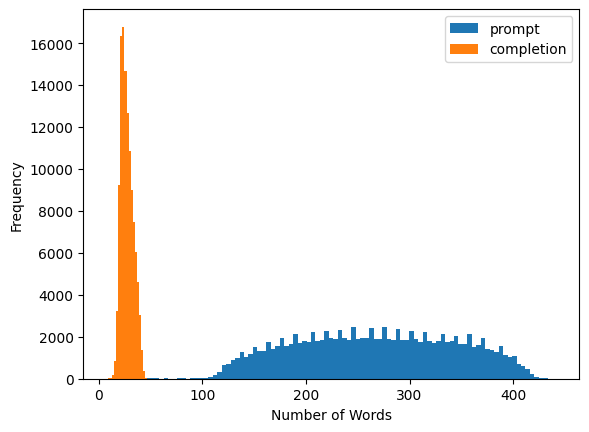

In [ ]:
import matplotlib.pyplot as plt



plt.hist(n_words_prompt, bins=100, label="prompt")
plt.hist(n_words_completion, bins = 20, label = "completion")
plt.ylabel("Frequency")
plt.xlabel("Number of Words")
plt.legend()
plt.show()

array([[<Axes: xlabel='prompt', ylabel='prompt'>,
        <Axes: xlabel='completion', ylabel='prompt'>,
        <Axes: xlabel='title', ylabel='prompt'>],
       [<Axes: xlabel='prompt', ylabel='completion'>,
        <Axes: xlabel='completion', ylabel='completion'>,
        <Axes: xlabel='title', ylabel='completion'>],
       [<Axes: xlabel='prompt', ylabel='title'>,
        <Axes: xlabel='completion', ylabel='title'>,
        <Axes: xlabel='title', ylabel='title'>]], dtype=object)

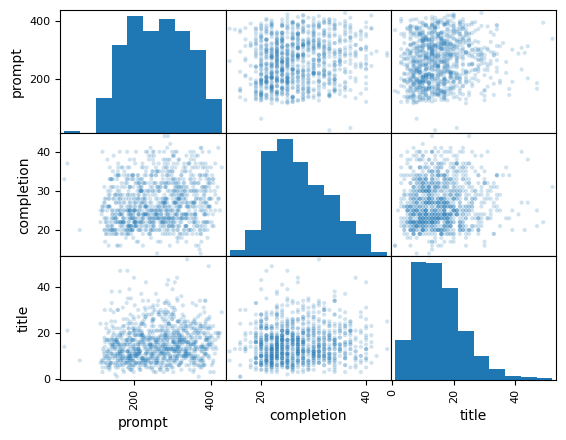

In [ ]:
pd.plotting.scatter_matrix(counts.iloc[0:1000, :], alpha=0.2)

In [ ]:
# correlation?
print(scipy.stats.linregress(n_words_prompt, n_words_completion))
print(scipy.stats.linregress(n_words_prompt, n_words_title))
print(scipy.stats.linregress(n_words_title, n_words_completion))

LinregressResult(slope=np.float64(0.009730547772109986), intercept=np.float64(24.429398166892913), rvalue=np.float64(0.12825565218894833), pvalue=np.float64(0.0), stderr=np.float64(0.00022023506420592163), intercept_stderr=np.float64(0.061112264004069335))
LinregressResult(slope=np.float64(0.010078636068001632), intercept=np.float64(13.10047346996971), rvalue=np.float64(0.10035856680827161), pvalue=np.float64(6.267295155282333e-259), stderr=np.float64(0.0002924667588345225), intercept_stderr=np.float64(0.08115558638563625))
LinregressResult(slope=np.float64(0.07443448768270909), intercept=np.float64(25.846643609629673), rvalue=np.float64(0.09852824352011469), pvalue=np.float64(1.329360595026525e-249), stderr=np.float64(0.002200505707993345), intercept_stderr=np.float64(0.03874319697777635))
